In [1]:
import numpy as np
from utils import *
from viz import *
from metrics import *
from sklearn.metrics import normalized_mutual_info_score
%matplotlib inline

# Evaluating Latent Temporal Labelings

In this notebook, we'll discuss shortcomings of existing evaluation criteria for latent temporal labelings and introduce new evaluation criteria. This is very useful for you if you're someone who applies unsupervised learning methods to any time-series data, such as video. This will still be of interest to you even if you're performing supervised learning on time-series data.

We're specifically interested in the _external evaluation of temporal clusterings_. A temporal clustering is the labeling of a time-series (or many time-series) with discrete cluster labels. They're generated by unsupervised methods that are only given the time-series as input and output a labeling for each time-series _i.e._ the method doesn't use any ground-truth information. _External_ evaluation involves comparing our predicted temporal clusterings to ground-truth labelings using evaluation metrics.

Let's look at a quick example.

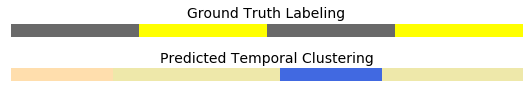

In [2]:
gt = np.repeat(list(range(2)) + list(range(2)), 30)
pred = np.repeat([2,3,4,3], [16, 26, 16, 22])
viz_temporal_clusterings([gt,pred], labels=['Ground Truth Labeling', 'Predicted Temporal Clustering'])

We can see above that we have a ground-truth labeling with 2 distinct labels spread over 4 segments. These could represent labels for a person's exercise (_walk, run, walk, run_) or labels for the video of a cooking recipe (_add ingredient, stir, add ingrdient, stir_).

Below it we have a prediction, provided by some method. Because we're in the unsupervised setting, the method can't actually output labels with semantic meaning (like _walk_), but only cluster identities (such as _cluster 1_). We've emphasized this here by coloring the predictions differently from ground-truth.

The question we're looking at is how well does the prediction agree with ground-truth labels?

That's all the setup we need to dive in!

## What's wrong with existing criteria?

There are a lot of criteria used for temporal clustering evaluation. We'll focus on the 2 most popular criteria,

* normalized mutual information score (NMI)
* accuracy under the Munkres algorithm (Munkres)

Most research uses these to compare competing methods that output temporal clusterings. NMI is an information-theoretic criterion originally designed to evaluate standard clusterings. The Munkres score attempts to find the optimal correspondence between clusters and ground-truth labels using the Munkres algorithm. Accuracy is computed under this correspondence (just like in a classification setting).

The easiest way to see how they fail is with an example -- below, we've constructed several different predictions for a particular ground-truth labeling. The problem is that _all of these predictions are deemed indistinguishable by these metrics_.

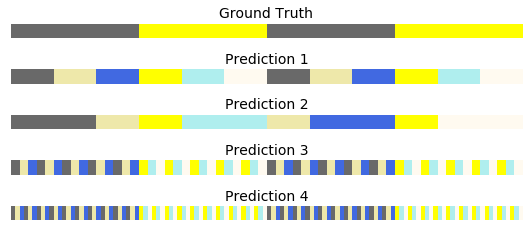

Scores for Prediction 1
	NMI Score: 0.62
	Munkres Score: 0.33
Scores for Prediction 2
	NMI Score: 0.62
	Munkres Score: 0.33
Scores for Prediction 3
	NMI Score: 0.62
	Munkres Score: 0.33
Scores for Prediction 4
	NMI Score: 0.62
	Munkres Score: 0.33


In [3]:
# Create a ground-truth labeling with some predictions
gt = np.repeat(list(range(2)) + list(range(2)), 30)
preds = [np.repeat([0, 3, 4, 1, 5, 6] * 2, [10, 10, 10, 10, 10, 10] * 2), 
         np.repeat([0, 0, 3, 1, 5, 5, 3, 4, 4, 1, 6, 6], [10, 10, 10, 10, 10, 10] * 2), 
         np.repeat([0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6] + 
                   [0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6], 
                   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] * 2),
         np.repeat([0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6] + 
                   [0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6], 
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] * 2)]

# Visualize
pred_labels = ['Prediction %d' % (i+1) for i in range(len(preds))]
viz_temporal_clusterings([gt] + preds, labels=['Ground Truth'] + pred_labels)
# Compute scores under NMI and Munkres
preds_nmi = [normalized_mutual_info_score(gt, e) for e in preds]
preds_munkres = [munkres_score([gt], [e]) for e in preds]
# Print scores
for i in range(len(preds)):
    print('Scores for Prediction %d' % (i+1))
    print('\tNMI Score: %1.2f\n'
          '\tMunkres Score: %1.2f' % (preds_nmi[i], preds_munkres[i]))

Neither score can evaluate the differences between these temporal clusterings. However, to a human observer, all of these predictions look very different qualitatively. This illustrates that the evaluation protocols being used are not in line with what we might expect qualitatively.

---

## New evaluation criteria

We'll introduce several new evaluation criteria that address the challenges we noted before. In fact, as we'll show at the end, the 4 predictions above can be scored properly with our evaluation criteria. Stay tuned till the end for that!


### Scoring Repeated Structure

To begin, let's look at the first aspect that's unique to temporal clusterings -- the presence of _repeated structure_ -- and how we could score it. 

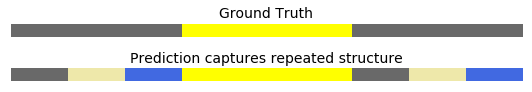

In [4]:
gt = np.repeat(list(range(2)) + list(range(1)), 30)
preds = [np.repeat([0, 3, 4, 1, 0, 3, 4], [10, 10, 10, 30, 10, 10, 10])]
pred_labels = ['Prediction captures repeated structure']
viz_temporal_clusterings([gt] + preds, labels=['Ground Truth'] + pred_labels)

The visualization above shows a case where one of the ground-truth labels is split across two segments. The prediction captures this repeated structure, by using the same sequence of clusters for both segments. Here's another visualization that makes this more explicit.

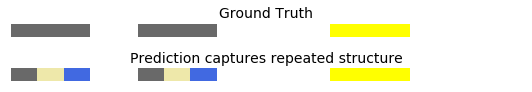

In [5]:
viz_temporal_clusterings_by_segments(gt, preds, labels=['Ground Truth'] + pred_labels)

In this visualization we've split up predictions for each ground-truth segment and grouped them by ground-truth labels. We can see that the predictions are consistent for the segments on the left.

This type of temporal structure can't be scored with existing metrics. We'll introduce the _repeated structure score (RSS)_ for this purpose.

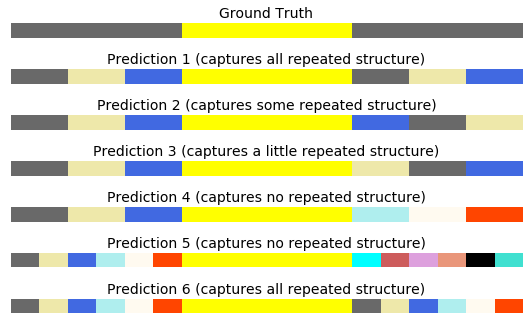

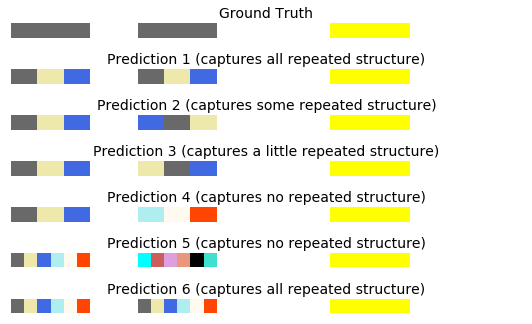

Score for Prediction 1
	Repeated Structure Score: 1.00 

Score for Prediction 2
	Repeated Structure Score: 0.87 

Score for Prediction 3
	Repeated Structure Score: 0.73 

Score for Prediction 4
	Repeated Structure Score: 0.60 

Score for Prediction 5
	Repeated Structure Score: 0.60 

Score for Prediction 6
	Repeated Structure Score: 1.00 



In [6]:
gt = np.repeat(list(range(2)) + list(range(1)), 30)
preds = [np.repeat([0, 3, 4, 1] + [0, 3, 4], [10, 10, 10, 30, 10, 10, 10]), 
         np.repeat([0, 3, 4, 1] + [4, 0, 3], [10, 10, 10, 30, 10, 10, 10]),
         np.repeat([0, 3, 4, 1] + [3, 0, 4], [10, 10, 10, 30, 10, 10, 10]),
         np.repeat([0, 3, 4, 1] + [5, 6, 7], [10, 10, 10, 30, 10, 10, 10]),
         np.repeat([0, 3, 4, 5, 6, 7, 1] + [8, 9, 10, 11, 12, 13], [5, 5, 5, 5, 5, 5, 30, 5, 5, 5, 5, 5, 5]),
        np.repeat([0, 3, 4, 5, 6, 7, 1] + [0, 3, 4, 5, 6, 7], [5, 5, 5, 5, 5, 5, 30, 5, 5, 5, 5, 5, 5])]
pred_labels = ['Prediction 1 (captures all repeated structure)', 
               'Prediction 2 (captures some repeated structure)',
               'Prediction 3 (captures a little repeated structure)',
               'Prediction 4 (captures no repeated structure)',
               'Prediction 5 (captures no repeated structure)', 
               'Prediction 6 (captures all repeated structure)']
viz_temporal_clusterings([gt] + preds, labels=['Ground Truth'] + pred_labels)
viz_temporal_clusterings_by_segments(gt, preds, labels=['Ground Truth'] + pred_labels)
preds_rss = [repeated_structure_score(gt, e, similarity_fn=heaviest_common_substring) for e in preds]

for i in range(len(preds)):
    print('Score for Prediction %d' % (i+1))
    print('\tRepeated Structure Score: %1.2f \n' % (preds_rss[i]))

We've considered several different predictions above, each labeled with a qualitative assessment of the repeated structure being captured. We can see how the RSS allows us to capture this intuition in a score -- predictions 4 and 5 are adjudged to be the worst, while predictions 1 and 6 are the best.

---

### Scoring Segment Structure

Next, we'll look at the second aspect that's unique to temporal clusterings -- _segment structure_. In temporal clusterings, clusters are split across multiple segments, and we need to systematically score how well predicted segments line up with ground-truth segments. Secondly, we also need to assess if the clusters we predict are homogenous (don't mix ground-truth labels) and complete (don't split up a ground-truth label). 

For the first issue, we'll talk about new evaluation criteria that score how faithfully transitions in ground-truth are recovered in predictions -- the _label agnostic segmentation score_. For the second issue, we've extended classical clustering evaluation criteria called homogeneity and completeness to handle segments -- _segmental homogeneity and segmental completeness_. Finally we'll combine all of these criteria into a single score, the _segment structure score (SSS)_.

---
The first set of evaluation criteria we describe are label-agnostic -- they don't depend on what the actual labels are in either the ground-truth or the prediction. They only depend on transition points where labels switch. These criteria can thus also be used to evaluate supervised learning methods.

We'll show 3 criteria,
* _Label-agnostic oversegmentation score (LASS-O)_: a measure of whether the prediction added in new transitions
* _Label-agnostic undersegmentation score (LASS-U)_: a measure of whether the prediction removed transitions
* _Label-agnostic segmentation score (LASS)_: an overall score of how faithfully transitions in ground-truth were respected

Let's take a look at how these work in practice.

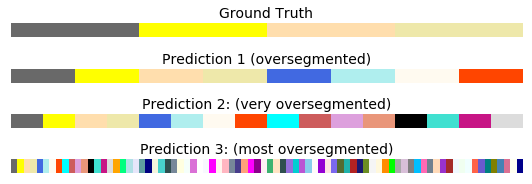

Scores for Prediction 1
	Label Agnostic Undersegmentation Score: 1.00 
	Label Agnostic Oversegmentation Score: 0.67 
	Label Agnostic Segmentation Score: 0.80 
Scores for Prediction 2
	Label Agnostic Undersegmentation Score: 1.00 
	Label Agnostic Oversegmentation Score: 0.50 
	Label Agnostic Segmentation Score: 0.67 
Scores for Prediction 3
	Label Agnostic Undersegmentation Score: 1.00 
	Label Agnostic Oversegmentation Score: 0.32 
	Label Agnostic Segmentation Score: 0.48 


In [7]:
gt = np.repeat(range(4),20)
pred_oversegmented_1 = np.repeat(range(8),10)
pred_oversegmented_2 = np.repeat(range(16),5)
pred_oversegmented_3 = np.repeat(range(80),1)
viz_temporal_clusterings([gt, pred_oversegmented_1, pred_oversegmented_2, pred_oversegmented_3], \
                         labels=['Ground Truth', 'Prediction 1 (oversegmented)', \
                                 'Prediction 2: (very oversegmented)', \
                                 'Prediction 3: (most oversegmented)'])
p1_lass_u = label_agnostic_undersegmentation_score(gt, pred_oversegmented_1)
p1_lass_o = label_agnostic_oversegmentation_score(gt, pred_oversegmented_1) 
p1_lass = label_agnostic_segmentation_score(gt, pred_oversegmented_1)
p2_lass_u = label_agnostic_undersegmentation_score(gt, pred_oversegmented_2)
p2_lass_o = label_agnostic_oversegmentation_score(gt, pred_oversegmented_2) 
p2_lass = label_agnostic_segmentation_score(gt, pred_oversegmented_2)
p3_lass_u = label_agnostic_undersegmentation_score(gt, pred_oversegmented_3)
p3_lass_o = label_agnostic_oversegmentation_score(gt, pred_oversegmented_3) 
p3_lass = label_agnostic_segmentation_score(gt, pred_oversegmented_3)
print('Scores for Prediction 1')
print('\tLabel Agnostic Undersegmentation Score: %1.2f \n\tLabel Agnostic Oversegmentation Score: %1.2f \n\tLabel Agnostic Segmentation Score: %1.2f ' % (p1_lass_u, p1_lass_o, p1_lass))
print('Scores for Prediction 2')
print('\tLabel Agnostic Undersegmentation Score: %1.2f \n\tLabel Agnostic Oversegmentation Score: %1.2f \n\tLabel Agnostic Segmentation Score: %1.2f ' % (p2_lass_u, p2_lass_o, p2_lass))
print('Scores for Prediction 3')
print('\tLabel Agnostic Undersegmentation Score: %1.2f \n\tLabel Agnostic Oversegmentation Score: %1.2f \n\tLabel Agnostic Segmentation Score: %1.2f ' % (p3_lass_u, p3_lass_o, p3_lass))

Above, we've generated 3 predictions that increasingly segment the ground-truth by introducing extra transitions, which is reflected by both LASS-O and LASS. These scores get increasingly worse as the predictions oversegment. Since LASS-U only measures undersegmentation, it remains constant for all 3 predictions.

Let's look at what happens if we had undersegmented predictions instead.

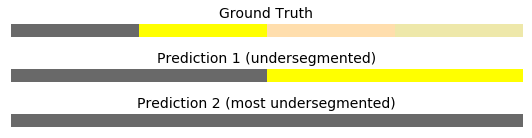

Scores for Prediction 1
	Label Agnostic Undersegmentation Score: 0.50 
	Label Agnostic Oversegmentation Score: 1.00 
	Label Agnostic Segmentation Score: 0.67 
Scores for Prediction 2
	Label Agnostic Undersegmentation Score: 0.00 
	Label Agnostic Oversegmentation Score: 1.00 
	Label Agnostic Segmentation Score: 0.00 


In [8]:
pred_undersegmented_1 = np.repeat(range(2),40)
pred_undersegmented_2 = np.repeat(range(1),80)
viz_temporal_clusterings([gt, pred_undersegmented_1, pred_undersegmented_2], \
                         labels=['Ground Truth', 
                                 'Prediction 1 (undersegmented)', \
                                 'Prediction 2 (most undersegmented)'])
p1_lass_u = label_agnostic_undersegmentation_score(gt, pred_undersegmented_1)
p1_lass_o = label_agnostic_oversegmentation_score(gt, pred_undersegmented_1) 
p1_lass = label_agnostic_segmentation_score(gt, pred_undersegmented_1)
p2_lass_u = label_agnostic_undersegmentation_score(gt, pred_undersegmented_2)
p2_lass_o = label_agnostic_oversegmentation_score(gt, pred_undersegmented_2) 
p2_lass = label_agnostic_segmentation_score(gt, pred_undersegmented_2)
print('Scores for Prediction 1')
print('\tLabel Agnostic Undersegmentation Score: %1.2f \n\tLabel Agnostic Oversegmentation Score: %1.2f \n\tLabel Agnostic Segmentation Score: %1.2f ' % (p1_lass_u, p1_lass_o, p1_lass))
print('Scores for Prediction 2')
print('\tLabel Agnostic Undersegmentation Score: %1.2f \n\tLabel Agnostic Oversegmentation Score: %1.2f \n\tLabel Agnostic Segmentation Score: %1.2f ' % (p2_lass_u, p2_lass_o, p2_lass))

This time, the LASS-O is constant for both predictions, while the LASS-U and LASS both reflect the fact that our predictions increasingly undersegment the ground-truth.

We'll do one last experiment with these scores, this time on cases where the transition boundaries are shifted in the prediction.

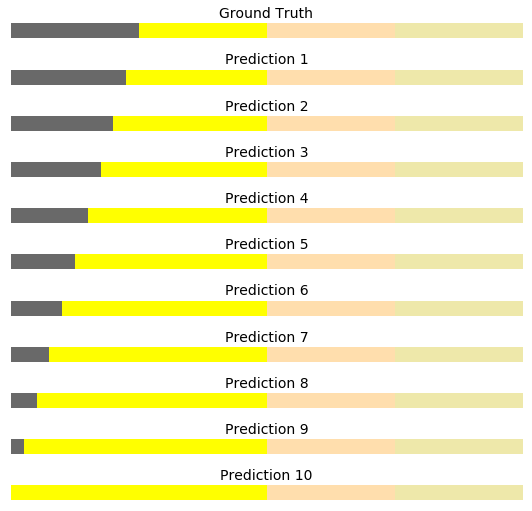

Scores for Prediction 1
	Label Agnostic Undersegmentation Score: 0.94 
	Label Agnostic Oversegmentation Score: 0.94 
	Label Agnostic Segmentation Score: 0.94 

Scores for Prediction 2
	Label Agnostic Undersegmentation Score: 0.90 
	Label Agnostic Oversegmentation Score: 0.91 
	Label Agnostic Segmentation Score: 0.91 

Scores for Prediction 3
	Label Agnostic Undersegmentation Score: 0.87 
	Label Agnostic Oversegmentation Score: 0.89 
	Label Agnostic Segmentation Score: 0.88 

Scores for Prediction 4
	Label Agnostic Undersegmentation Score: 0.85 
	Label Agnostic Oversegmentation Score: 0.87 
	Label Agnostic Segmentation Score: 0.86 

Scores for Prediction 5
	Label Agnostic Undersegmentation Score: 0.83 
	Label Agnostic Oversegmentation Score: 0.87 
	Label Agnostic Segmentation Score: 0.85 

Scores for Prediction 6
	Label Agnostic Undersegmentation Score: 0.81 
	Label Agnostic Oversegmentation Score: 0.87 
	Label Agnostic Segmentation Score: 0.84 

Scores for Prediction 7
	Label Agnostic 

In [9]:
preds = [np.repeat(range(4), [20 - i, 20 + i, 20, 20]) for i in range(2, 21, 2)]
pred_labels = ['Prediction %d' % (i+1) for i in range(10)]
viz_temporal_clusterings([gt] + preds, labels=['Ground Truth'] + pred_labels)
preds_lass_u = [label_agnostic_undersegmentation_score(gt, e) for e in preds]
preds_lass_o = [label_agnostic_oversegmentation_score(gt, e) for e in preds]
preds_lass = [label_agnostic_segmentation_score(gt, e) for e in preds]
for i in range(len(preds)):
    print('Scores for Prediction %d' % (i+1))
    print('\tLabel Agnostic Undersegmentation Score: %1.2f \n'
          '\tLabel Agnostic Oversegmentation Score: %1.2f \n'
          '\tLabel Agnostic Segmentation Score: %1.2f \n' % (preds_lass_u[i], preds_lass_o[i], preds_lass[i]))

A shifted transition can be seen as the combination of a removal and addition of a transition. In the examples above, we can see that both the LASS-O and LASS-U (and consequently the LASS) are affected as the prediction shifts. The LASS reflects a compromise between these two extremes and gives an overall picture of how well the prediction captures the transitions in terms of over/undersegmentation as well as shifted transitions.

However, the fact that the LASS is label-agnostic means that it can't score many cases. To account for these cases, we'll simply extend classical clustering metrics (completeness and homogeneity) and use them. And lastly, we'll need a combined criteria that balances all of these considerations -- we'll call this the _segment structure score (SSS)_. 

Let's look at another example to understand these cases, as well as the SSS.

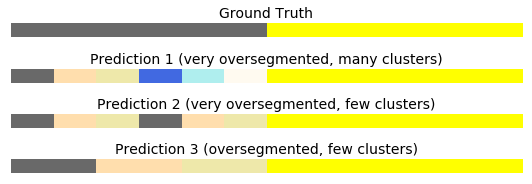

Scores for Prediction 1
	Label Agnostic Undersegmentation Score: 1.00 
	Label Agnostic Oversegmentation Score: 0.44 
	Label Agnostic Segmentation Score: 0.61 
	Segmental Completeness Score: 0.44 
	Segmental Homogeneity Score: 1.00 
	Segment Structure Score: 0.61 

Scores for Prediction 2
	Label Agnostic Undersegmentation Score: 1.00 
	Label Agnostic Oversegmentation Score: 0.44 
	Label Agnostic Segmentation Score: 0.61 
	Segmental Completeness Score: 0.56 
	Segmental Homogeneity Score: 1.00 
	Segment Structure Score: 0.66 

Scores for Prediction 3
	Label Agnostic Undersegmentation Score: 1.00 
	Label Agnostic Oversegmentation Score: 0.56 
	Label Agnostic Segmentation Score: 0.72 
	Segmental Completeness Score: 0.56 
	Segmental Homogeneity Score: 1.00 
	Segment Structure Score: 0.72 



In [12]:
gt = np.repeat(range(2),30)
preds = [np.repeat([0,2,3,4,5,6,1], [5, 5, 5, 5, 5, 5, 30]), 
         np.repeat([0,2,3,0,2,3,1], [5, 5, 5, 5, 5, 5, 30]),
         np.repeat([0,2,3,1], [10, 10, 10, 30])]
pred_labels = ['Prediction 1 (very oversegmented, many clusters)', 
               'Prediction 2 (very oversegmented, few clusters)',
               'Prediction 3 (oversegmented, few clusters)']
viz_temporal_clusterings([gt] + preds, labels=['Ground Truth'] + pred_labels)
preds_lass_u = [label_agnostic_undersegmentation_score(gt, e) for e in preds]
preds_lass_o = [label_agnostic_oversegmentation_score(gt, e) for e in preds]
preds_lass = [label_agnostic_segmentation_score(gt, e) for e in preds]
preds_seg_com = [segment_completeness_score(gt, e) for e in preds]
preds_seg_hom = [segment_homogeneity_score(gt, e) for e in preds]
preds_sss = [segment_structure_score(gt, e) for e in preds]
for i in range(len(preds)):
    print('Scores for Prediction %d' % (i+1))
    print('\tLabel Agnostic Undersegmentation Score: %1.2f \n'
          '\tLabel Agnostic Oversegmentation Score: %1.2f \n'
          '\tLabel Agnostic Segmentation Score: %1.2f \n'
          '\tSegmental Completeness Score: %1.2f \n'
          '\tSegmental Homogeneity Score: %1.2f \n'
          '\tSegment Structure Score: %1.2f \n' % (preds_lass_u[i], preds_lass_o[i], preds_lass[i], preds_seg_com[i], preds_seg_hom[i], preds_sss[i]))

We're showing 3 predictions above. Predictions 1 and 2 have the same LASS since their transitions are at exactly the same places. On the other hand, predictions 2 and 3 have the same segmental completeness and segmental homogeneity scores since the compositions of the predictions under each ground-truth segment are the same (we've preserved the same proportions). Neither of these 2 sets of criteria is thus sufficient for us to differentiate these 3 cases.

Intuitively, we would expect that prediction 3 should be scored better than prediction 2, which is better than prediction 1. The SSS combines all of these criteria into a single score, and reflects this ordering. 

---

### Putting it all together

Lastly, we'll combine the repeated structure score and the segment structure score to get a single metric -- the _temporal structure score (TSS)_. The TSS provides a weighted harmonic mean of the RSS and SSS (much like the NMI is a weighted harmonic mean of completeness and homogeneity). We'll weigh both the RSS and SSS equally here.

Let's circle back to the examples that the existing criteria were unable to differentiate and score them with our metrics.

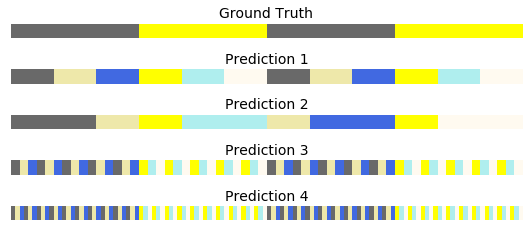

Scores for Prediction 1
	Repeated Structure Score: 1.00 
	Segment Structure Score: 0.65 
	Temporal Structure Score: 0.79 
	NMI Score: 0.62
	Munkres Score: 0.33
Scores for Prediction 2
	Repeated Structure Score: 0.67 
	Segment Structure Score: 0.78 
	Temporal Structure Score: 0.72 
	NMI Score: 0.62
	Munkres Score: 0.33
Scores for Prediction 3
	Repeated Structure Score: 1.00 
	Segment Structure Score: 0.52 
	Temporal Structure Score: 0.69 
	NMI Score: 0.62
	Munkres Score: 0.33
Scores for Prediction 4
	Repeated Structure Score: 1.00 
	Segment Structure Score: 0.48 
	Temporal Structure Score: 0.65 
	NMI Score: 0.62
	Munkres Score: 0.33


In [14]:
# Create a ground-truth labeling with some predictions
gt = np.repeat(list(range(2)) + list(range(2)), 30)
preds = [np.repeat([0, 3, 4, 1, 5, 6] * 2, [10, 10, 10, 10, 10, 10] * 2), 
         np.repeat([0, 0, 3, 1, 5, 5, 3, 4, 4, 1, 6, 6], [10, 10, 10, 10, 10, 10] * 2), 
         np.repeat([0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6] + 
                   [0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6], 
                   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] * 2),
         np.repeat([0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6] + 
                   [0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6], 
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] * 2)]

# Visualize
pred_labels = ['Prediction %d' % (i+1) for i in range(len(preds))]
viz_temporal_clusterings([gt] + preds, labels=['Ground Truth'] + pred_labels)
# Compute scores under TSS, NMI and Munkres
preds_rss = [repeated_structure_score(gt, e, similarity_fn=heaviest_common_substring) for e in preds]
preds_sss = [segment_structure_score(gt, e) for e in preds]
preds_tss = [temporal_structure_score(gt, e, similarity_fn=heaviest_common_substring) for e in preds]
preds_nmi = [normalized_mutual_info_score(gt, e) for e in preds]
preds_munkres = [munkres_score([gt], [e]) for e in preds]
# Print scores
for i in range(len(preds)):
    print('Scores for Prediction %d' % (i+1))
    print('\tRepeated Structure Score: %1.2f \n\tSegment Structure Score: %1.2f \n\tTemporal Structure Score: %1.2f \n\tNMI Score: %1.2f\n'
          '\tMunkres Score: %1.2f' % (preds_rss[i], preds_sss[i], preds_tss[i], preds_nmi[i], preds_munkres[i]))

The evaluation criteria we've introduced allow us to differentiate all of these predictions.

We hope you use these metrics in your work, as well as the visualization code!